In [ ]:
import os
import pickle
import random
import time
import re
import itertools
import math
import json
from pathlib import Path
import warnings

# globally ignore all warnings
warnings.filterwarnings("ignore")

import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset,TensorDataset,Subset
import torch.multiprocessing as mp
from torchinfo import summary


from utils import preprocessing as ppsr
from utils.potsimloader import potsimloader as psl
from utils import split
from models import forecast_enc_transformer
from sklearn.preprocessing import MinMaxScaler
from utils import scaler
from training import train
from testing import evaluate
pl.enable_string_cache()

In [ ]:
# #Part of Preprocessing.py file,mentioned here for additional clarity.
# #function that geneartes treatment combination IDs for a given treatment valaues as an array
# def generate_treatments(n_values):
#     combis = list(itertools.product(n_values, repeat=3))
#     return ["-".join(map(str, t)) for t in combis if sum(t) <= 400]

# #Dataset is presented yearly, this definition merges all parques together and makes a single large data file
# def join_potsim_yearly(data_dir, save_dir=Path("data")):
#     data_dir = Path(data_dir).resolve()
#     files = os.listdir(data_dir)
#     pattern = re.compile(r"^potsim_\d{4}\.parquet$")
#     files = sorted([file for file in files if pattern.match(file)])
#     files = [data_dir / file for file in files]
#     df = pl.scan_parquet(files)
#     filepath = save_dir / "potsim.parquet"
#     df.sink_parquet(
#         filepath,
#         statistics=True,
#         compression="zstd",
#         compression_level=1,
#         row_group_size=1_000_000,
#     )

# #this is to specify what columns in the dataset are going to be used
# usecols = ['Year', 'Date', 'Treatment', 'NFirstApp','PlantingDay', 'IrrgDep',
#            'IrrgThresh', 'DayAfterPlant', 'NApp', 'NLeach', 'NPlantUp', 'NTotL1', 
#            'NTotL2', 'Irrg', 'SWatL1', 'SWatL2', 'Rain', 'SolarRad', 'AirTempC']

# #This masking is done to level both the array sizes.The number of days in crop cycle changes for these settings, 
# # so this amsking would help bring oth of them to a same array size bya dding some dummies wherever needed.
# mask = (
#     ((pl.col("NFirstApp") == "Npl") & (pl.col("DayAfterPlant") >= -1)) |
#     ((pl.col("NFirstApp") == "Npre") & (pl.col("DayAfterPlant") >= -37))
# )

# #MEtnioning the File paths and merging the dataset 
# potsim_yearly_dir = Path("data/potsim_yearly")
# weather_file = Path("data") / "weather.parquet"
# data_file = Path("data") / "potsim.parquet"
# if not data_file.exists():
#     join_potsim_yearly(potsim_yearly_dir)


# Sceanrios filter
#[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]
#[2001,2002,2003,2004,2005,2006,2007]
# sceanrio_filter = {
#     "Year":[2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],
#     "PlantingDay": [22,43],
#     "Treatment": generate_treatments([56,112,168,0,196]),
#     "IrrgThresh": [70],
#     "IrrgDep": [30],
#     "NFirstApp": "Npl"
# }

# data = psl.read_data(
#     dataset_path = data_file,
#     weather_path = weather_file,
#     usecols = usecols,
#     scenarios=sceanrio_filter,
#     lazy = False
# )
# print("Saving the dataset for later use.")

The above code is bypassed as we have already run it and saved the data in the xls file,shown below. 
You can uncomment the above lines annd can run it to get the same xls file

In [46]:

data=pd.read_excel("data/data_forc.xlsx")


In [70]:
#Feature Processing and data scaling

In [ ]:

X,y= data[['PlantingDay', 'DayAfterPlant', 'NApp','Rain', 'SolarRad', 'AirTempC']], data['NLeach']
y=np.array(y).reshape(y.shape[0],1)
req_cols=['Year','Treatment','PlantingDay','DayAfterPlant','NApp','Rain','SolarRad','AirTempC','NLeach']
data_cols=data[req_cols]
copy_data=data_cols.copy()
copy_data.iloc[:,3:].fillna(0,inplace=True)
scaler=MinMaxScaler()
copy_data.iloc[:,3:]=scaler.fit_transform(copy_data.iloc[:,3:])

In [ ]:
def get_ip_op(data_cols):
    #This definition will divide the data such that every example covers crop cycle length of features, the final 
    #result having the shape (#examples,#crop cycle or episode length, #features)
    inp_data=[]
    op_data=[]
    op_data_l=[]
    for yr in data_cols['Year'].unique():
        for tmt in data_cols['Treatment'].unique():
              for days in data_cols['PlantingDay'].unique():
                  base=data_cols[(data_cols['Year']==yr)&(data_cols['Treatment']==tmt)&(data_cols['PlantingDay']==days)]
                  inp_data.append(base.iloc[:,3:-1].to_numpy())
                  op_data.append(base['NLeach'].to_numpy())
                  op_data_l.append(base['NLeach'].iloc[-1])
              
    return inp_data,op_data,op_data_l



In [71]:
def get_scen(data_cols,year,tmt,pl_day):
    #Retreives a particular scenario from given data. Helpful during inference. 
    base=data_cols[(data_cols['Year']==year)&(data_cols['Treatment']==tmt)&(data_cols['PlantingDay']==pl_day)]
    inp=base.iloc[:,3:-1].to_numpy()
    op=base['NLeach'].to_numpy()
    #Converting them to tensors
    inp=torch.tensor(inp).float()
    op=torch.tensor(op).float()

              
    return inp,op

In [ ]:
#Converting to tensors and data types
inp,op,op_l=get_ip_op(copy_data)
op=np.array(op,dtype=np.float32)
op_l=np.array(op_l,dtype=np.float32)
#getting input and output tensors
inp=torch.tensor(inp)
op=torch.tensor(op).unsqueeze(2)
inp=inp.float()
op=op.float()

Hyperparametrs setup

In [ ]:
window_size = 40
batch_size  = 32
epochs      = 30
lr          = 0.001

Dataset setup

In [ ]:
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_in = inp.float().to(device)    # [N_eps,155,4]
data_op = op.float().to(device)     # [N_eps,155,1]
N_eps   = data_in.size(0)
H       = data_op.size(1) - window_size  # forecast horizon

#Checking the shapes of input and output
print(data_in.shape,data_op.shape)

class TuberDataset(Dataset):
    def __init__(self, X, Y, w):
        self.X = X
        self.Y = Y
        self.w = w
    def __len__(self):
        return self.X.size(0)
    def __getitem__(self, idx):
        x = self.X[idx, :self.w, :]     # [w,5]
        y = self.Y[idx, self.w:, :]     # [H,1]
        return x, y

full_ds     = TuberDataset(data_in, data_op, window_size)
idx         = torch.randperm(N_eps)
n_tr        = int(0.7*N_eps)
n_val       = int(0.15*N_eps)
train_idx   = idx[:n_tr]
val_idx     = idx[n_tr:n_tr+n_val]
test_idx    = idx[n_tr+n_val:]

train_loader = DataLoader(Subset(full_ds, train_idx), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(Subset(full_ds, val_idx),   batch_size=batch_size)
test_loader  = DataLoader(Subset(full_ds, test_idx),  batch_size=1)





In [ ]:
# instantiate the model.
F     = data_in.size(2)
model = forecast_enc_transformer.ForecastTransformerEncOnly(num_features=F,
                                   horizon=H).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=lr)
crit  = nn.MSELoss()

In [ ]:
#Reteiving the saved weights for this model
saved_model_file="saves/NLeach/NLeach_forecasting_EncoderOnnlyTransformer.pth"

In [ ]:
#Loading the model with saved weights
model.load_state_dict(torch.load(saved_model_file))

<All keys matched successfully>

 VISUALIZATION ON A SINGLE EPISODE

In [ ]:
def plot_episode(model,data,year,tmt,pl,w):

    """
    inp_full: [N_eps,155,4], op_full: [N_eps,155,1]
    """
    inp_full,op_full=get_scen(data,year,tmt,pl)
    model.eval()
    device = next(model.parameters()).device

    # select one example
    x = inp_full[:w, :].unsqueeze(0).to(device)  # (1, w, 4)
    with torch.no_grad():
        pred = model(x)                                 # (1, H, 1)

    # convert to numpy
    pred   = pred.squeeze(0).squeeze(-1).cpu().numpy()    # (H,)
    actual = op_full[w:].cpu().numpy()           # (H,)

    
    # plot
    plt.figure()
    plt.plot(range(w, w+len(pred)), pred,   label='Predicted')
    plt.plot(range(w, w+len(actual)), actual, label='Actual')
    plt.xlabel('Timestep')
    plt.ylabel('Value')
    plt.title(f'Forecasting Treatment:',)
    plt.legend()
    plt.show()

    return pred,actual



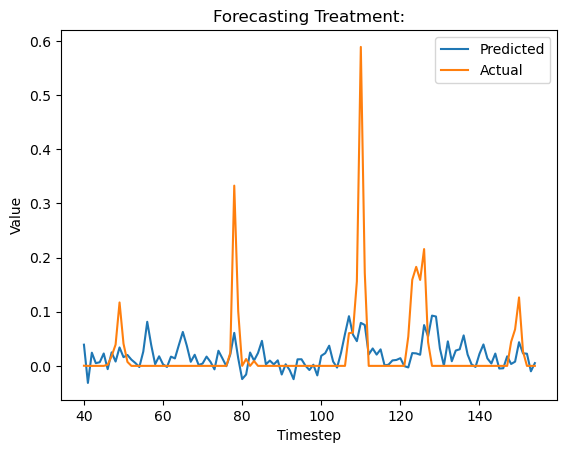

In [69]:
pred,act=plot_episode(model,copy_data,2023,"56-168-112",pl=43, w=window_size)